# Математическое моделирование. Лабораторная работа 3.

 **Выполнил**: Клебанов Д.А, группа 853501, Вариант 10

In [1]:
from math import factorial as fact
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

**Задание**

Рассматривается простейшая одноканальная СМО с ограниченной очередью m = 2; работающий канал может иногда выходить из строя (отказывать). Заявка, которая обслуживается в момент отказа канала, становится в очередь, если в ней еще есть свободные места; если нет, она покидает СМО необслуженной. Интенсивность потока заявок X, потока обслуживании Y, потока отказов канала Z, потока восстановлений (ремонтов) R. Перечислить состояния СМО и найти для них финальные вероятности,  характеристики эффективности СМО: относительную и абсолютную пропускные способности системы, среднее время пребывания заявки в системе X = 2, Y = 1, Z = 0,5, R = 1.

In [2]:
class CustomQueuingSystem:
    def __init__(self, n, m, lmd, mu, nu, Z, R):
        self.n = n
        self.m = m
        self.lmd = lmd
        self.mu = mu
        self.nu = nu
        
        self.state = 0
        self.time = 0
        self._state_log = [(0, 0), ]
        
        self.forward_cnt = 0
        self.refuse_cnt = 0
        self.forward_times = []
        self.backward_times = []
        self.broken = 0
        self.Z = Z
        self.R = R
        
        self.custom_stat_log = []
    
    @property
    def state_log(self):
        return np.array(self._state_log)
    
    @property
    def backward_cnt(self):
        return len(self.backward_times)

    def get_forward_intensity(self):
        return self.lmd
    
    def get_backward_intensity(self):
        return min(self.state, self.n) * self.mu + max(self.state - self.n, 0) * self.nu
    
    def get_timedelta_by_intensity(self, intensity):
        # print(self.state, self.broken, intensity)
        if intensity == 0:
            return np.inf
        return np.random.exponential(1.0 / intensity)
    
    def process_forward(self, time_delta):
        self.time += time_delta
        self.forward_cnt += 1
        if self.state < self.n + self.m:
            self.state += 1
            if not self.broken:
                self.forward_times.append(self.time)
        else:
            self.refuse_cnt += 1

    def process_backward(self, time_delta):
        self.state -= 1
        self.time += time_delta
        self.backward_times.append(self.time)
        
    def process_event(self):
        # print(self.state, self.broken)
        if self.state == 3 and self.broken:
            raise RuntimeError()
        # print(self.state, self.broken)
        timedelta_forward = self.get_timedelta_by_intensity(self.get_forward_intensity())
        timedelta_backward = self.get_timedelta_by_intensity(self.get_backward_intensity() if not self.broken else 0)
        timedelta_forward_broken = self.get_timedelta_by_intensity(self.Z if not self.broken else 0)
        timedelta_backward_broken = self.get_timedelta_by_intensity(self.R if self.broken else 0)
        
        if timedelta_forward <= timedelta_backward and timedelta_forward <= timedelta_forward_broken and timedelta_forward <= timedelta_backward_broken:
            self.process_forward(timedelta_forward)        
        elif timedelta_backward <= timedelta_forward and timedelta_backward <= timedelta_forward_broken and timedelta_backward <= timedelta_backward_broken:
            self.process_backward(timedelta_backward)
        elif timedelta_forward_broken <= timedelta_backward and timedelta_forward_broken <= timedelta_forward and timedelta_forward_broken <= timedelta_backward_broken:
            broken = 1
            self.process_forward(timedelta_forward_broken)
        elif timedelta_backward_broken <= timedelta_backward and timedelta_backward_broken <= timedelta_forward_broken and timedelta_backward_broken <= timedelta_forward:
            self.process_backward(timedelta_backward_broken)
            broken = 0
        else:
            raise RuntimeError()
            
        self._state_log.append((self.state, self.time))
        
    @property
    def p(self):
        return (self.lmd + self.Z) / self.mu
    
    @property
    def beta(self):
        return self.nu / self.mu
    
    def _tfp_multiplier(self, i):
        return self.p ** i / fact(i)
    
    def _tfp_denominator_product(self, i):
        return np.prod([(self.n + l * self.beta) for l in range(1, i + 1)])
    
    @property
    def theoretical_final_probabilities(self):
        # print(QueuingSystem(1, 2, 2 +0.25, 1, 0).theoretical_final_probabilities)
        # return QueuingSystem(1, 2, 2 + 0.25, 1, 0).theoretical_final_probabilities
        multipliers = [self._tfp_multiplier(i) for i in range(self.n + 1)]
        p0_rest_part = sum([self.p ** i / self._tfp_denominator_product(i) for i in range(1, self.m + 1)])
        p0 = 1.0 / (sum(multipliers) + multipliers[self.n] * p0_rest_part)
        
        ans_n_part = list(map(lambda x: x * p0, multipliers))
        ans_rest_part = [p0 * multipliers[self.n] * self.p ** i / self._tfp_denominator_product(i) for i in range(1, self.m + 1)]
        return list(ans_n_part) + ans_rest_part
        
    @property
    def empirical_final_probabilities(self):
        counts = np.unique(self.state_log[:, 0], return_counts=True)[1]
        return counts / np.sum(counts)
    
    @property
    def theoretical_absolute_bandwidth(self):
        return (self.lmd + self.Z) * (1.0 - self.theoretical_final_probabilities[self.n + self.m])

    @property
    def empirical_absolute_bandwidth(self):
        return (self.lmd + self.Z) * self.backward_cnt / self.forward_cnt

    @property
    def theoretical_relative_bandwidth(self):
        return 1.0 - self.theoretical_final_probabilities[self.n + self.m]
    
    @property
    def empirical_relative_bandwidth(self):
        return self.backward_cnt / self.forward_cnt
    
    @property
    def theoretical_average_orders_in_system(self):
        return sum([self.n * self.theoretical_final_probabilities[self.n + i] for i in range(1, self.m + 1)]) \
            + sum([i * self.theoretical_final_probabilities[i] for i in range(1, self.n + 1)])
        
    @property
    def empirical_average_orders_in_system(self):
        return np.sum(list(map(lambda x: min(x, self.n), self.state_log[:, 0]))) / self.state_log.shape[0]
    
    @property
    def theoretical_average_orders_in_queue(self):
        return sum([i * self.theoretical_final_probabilities[self.n + i] for i in range(1, self.m + 1)])
        
    @property
    def empirical_average_orders_in_queue(self):
        return np.sum(list(map(lambda x: max(x - self.n, 0), self.state_log[:, 0]))) / self.state_log.shape[0]
    
    @property
    def theoretical_average_order_time_in_system(self):
        return self.theoretical_average_orders_in_queue / (self.lmd + self.Z) + self.theoretical_absolute_bandwidth / (self.lmd + self.Z) / self.mu
        
    @property
    def empirical_average_order_time_in_system(self):
        return self.empirical_average_orders_in_queue / (self.lmd + self.Z) + self.empirical_absolute_bandwidth / (self.lmd + self.Z) / self.mu

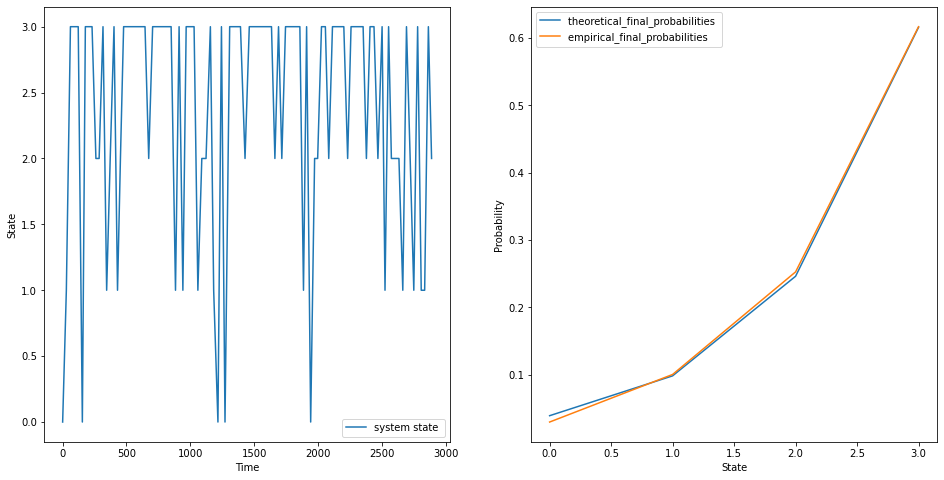

In [3]:
def emulate(ax, n, m, lmd, mu, nu, Z, R, param_name="", value=None):
    n_iter = 10000
    system = CustomQueuingSystem(n, m, lmd, mu, nu, Z, R)
    for _ in range(n_iter):
        system.process_event()

    sampled_state_log = system.state_log[::len(system._state_log) // 100]
    
    emulate_name = ""
    if value is not None:
        emulate_name = f'{param_name}={value}'
    
    ax[0].plot(sampled_state_log[:, 1], sampled_state_log[:, 0], label=f'system state {emulate_name}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('State')
    ax[0].legend()

    x_values = np.arange(system.n + system.m + 1)
    for name in ('theoretical_final_probabilities', 'empirical_final_probabilities'):
        ax[1].plot(x_values, getattr(system, name), label=name + ' ' + emulate_name)
    ax[1].set_xlabel('State')
    ax[1].set_ylabel('Probability')
    ax[1].legend()
    return system

# plt.figure()
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
system = emulate(ax, 1, 2, 2, 1, 0, 0.5, 1)
plt.show()

In [4]:
print(f'Theoretical absolute bandwidth: {system.theoretical_absolute_bandwidth}')
print(f'Empirical absolute bandwidth: {system.empirical_absolute_bandwidth}')

Theoretical absolute bandwidth: 0.960591133004926
Empirical absolute bandwidth: 0.9848062447727907


In [5]:
print(f'Theoretical relative bandwidth: {system.theoretical_relative_bandwidth}')
print(f'Empirical relative bandwidth: {system.empirical_relative_bandwidth}')

Theoretical relative bandwidth: 0.3842364532019704
Empirical relative bandwidth: 0.39392249790911626


In [6]:
print(f'Theoretical average order time in system: {system.theoretical_average_order_time_in_system}')
print(f'Empirical average order time in system: {system.empirical_average_order_time_in_system}')

Theoretical average order time in system: 0.9753694581280787
Empirical average order time in system: 0.9883430558533218
